In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import sys

sys.path.append("../")

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from machinelearning_control_fedbatch import generate_dataset, main

from src.utils import get_data_and_feed, plot_experiment

FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR01'
S_IN = 1.43 * 200

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
full_df, feeds = get_data_and_feed(
    file_name=FILENAME, experiment=EXPERIMENT, keep_only="FB"
)

full_df['Biomass'].iloc[1] = 5.0

# add new line to full_df to simulate an extra data point
new_row = pd.DataFrame([{"Process": "FB", "RTime": 5.85, "V": 1.56, "Biomass": 5.8, "Glucose": 0.013, "Protein": 0.0}])
full_df = pd.concat([full_df, new_row], ignore_index=True)
full_df.sort_values(by="RTime", inplace=True)

T_FB = full_df["RTime"].iloc[0] # Time of fed-batch
T_START = 0
T_END = full_df["RTime"].iloc[-1] - T_FB  # End of experiment

# inlet flowrate
def Fs(t):
    if t <= 4.73 - T_FB:
        return 0.017
    elif t <= 7.33 - T_FB:
        return 0.031
    elif t <= 9.17 - T_FB:
        return 0.060
    elif t <= 9.78 - T_FB:
        return 0.031
    else:
        return 0.017

# Get initial volume
V0 = full_df["V"].iloc[0]

# Normalize time
full_df["RTime"] = full_df["RTime"] - T_FB
feeds["Time"] = feeds["Time"] - T_FB

print(f"Dataset shape: {full_df.shape}")

plot_experiment(full_df, title='')

In [ ]:
from scipy.interpolate import interp1d

# Define the new RTime points for interpolation
new_RTime = np.arange(0, 6, 0.5)

# Create interpolation functions for V, Biomass, and Glucose
interp_V = interp1d(full_df['RTime'], full_df['V'], kind='linear', fill_value='extrapolate')
interp_Biomass = interp1d(full_df['RTime'], full_df['Biomass'], kind='linear', fill_value='extrapolate')
interp_Glucose = interp1d(full_df['RTime'], full_df['Glucose'], kind='linear', fill_value='extrapolate')

# Interpolate the values at new RTime points
new_V = interp_V(new_RTime)
new_Biomass = interp_Biomass(new_RTime)
new_Glucose = interp_Glucose(new_RTime)

# Create a DataFrame for the interpolated results
full_df = pd.DataFrame({
    'RTime': new_RTime,
    'V': new_V,
    'Biomass': new_Biomass,
    'Glucose': new_Glucose,
    'Induction': [0] * len(new_RTime)
})

plot_experiment(full_df, title='Interpolated data')

In [ ]:
full_df[['RTime', 'Biomass', 'Glucose', 'V']].describe().T[['min', 'max', 'mean']]

In [ ]:
# Get dataset (multiple initial conditions)
in_train, out_train = generate_dataset(data=full_df, num_points=1000)

In [ ]:
# parameter values
mumax = 0.7267     # 1/hour
Ks = 0.1634          # g/liter
Yxs = 0.3983         # g/g
Sin = 1.43 * 200  # g/liter

t_start = full_df['RTime'].iloc[0]
t_end = full_df['RTime'].iloc[-1]

# initial conditions
V0 = full_df['V'].iloc[0]
S0 = full_df['Glucose'].iloc[0]
X0 = full_df['Biomass'].iloc[0]

print(f'T_start = {t_start}')
print(f'T_end = {t_end}')

In [ ]:
if os.path.exists('pinc_trained_exp.pth'):
    net = torch.load("pinc_trained_exp.pth")
    print('Model loaded')
else:
    # Train network
    net = main(full_df, in_train, out_train, t_start, t_end, Sin, mumax, Ks, Yxs, verbose=10)
    torch.save(net, "pinc_trained_exp.pth")

# Autoregression

In [80]:
# Load the trained net
net = torch.load("pinc_trained_exp_v1.pth")
net

PINN(
  (input): Linear(in_features=5, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [81]:
import torch
from machinelearning_control_fedbatch import numpy_to_tensor

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

full_df['F'] = full_df['RTime'].apply(Fs)

T_s = 0.5
t_test = numpy_to_tensor(np.array([full_df["RTime"].values]))
X_test = numpy_to_tensor(np.array([full_df["Biomass"].values]))
S_test = numpy_to_tensor(np.array([full_df["Glucose"].values]))
V_test = numpy_to_tensor(np.array([full_df["V"].values]))
F_test = numpy_to_tensor(np.array([full_df["F"].values]))
u_test = torch.cat([t_test, X_test, S_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test], dim=1)

In [82]:
X_0 = X_test[0]
S_0 = S_test[0]
V_0 = V_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
V_preds = []

for i in range(len(u_test)):

    if i == 0:
        X_preds.append(X_0.item())
        S_preds.append(S_0.item())
        V_preds.append(V_0.item())
        continue

    x_k = net.forward(torch.tensor([T_s, X_0, S_0, V_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    V_0 = V_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())
    V_preds.append(x_k[2].item())

In [83]:
t_test = t_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
S_test = S_test.detach().cpu().numpy()
V_test = V_test.detach().cpu().numpy()

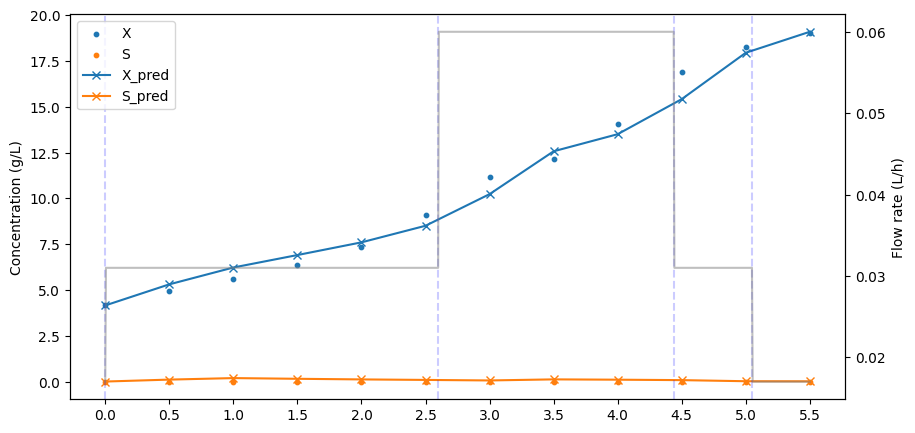

In [84]:
plt.figure(figsize=(10, 5))
plt.scatter(t_test, X_test, s=10, label="X")
plt.scatter(t_test, S_test, s=10, label="S")

plt.plot(t_test, X_preds, marker='x', label="X_pred")
plt.plot(t_test, S_preds, marker='x', label="S_pred")
plt.ylabel("Concentration (g/L)")
plt.legend(loc="best") 

# Add vertical lines for feed
for i in range(len(feeds)):
    plt.axvline(x=feeds["Time"].iloc[i], color='b', alpha=0.2, linestyle='--')

# plot the feed rate in secondary y-axis
plt.twinx()
t_f = np.linspace(0, 5.5, 1000)
plt.plot(t_f, [Fs(t) for t in t_f], color='gray', alpha=0.5)
plt.ylabel("Flow rate (L/h)")

plt.xticks(np.arange(0, 6, 0.5))
plt.xlabel("Time (h)")
plt.show()